### Datasets
http://www.manythings.org/anki/  (Download and unzip mar-eng.zip file)

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
lines= pd.read_table('mar.txt', names=['eng', 'mar'])

In [3]:
lines.shape

(33725, 2)

In [4]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.mar=lines.mar.apply(lambda x: x.lower())

In [5]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.mar=lines.mar.apply(lambda x: re.sub("'", '', x))

In [6]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.mar=lines.mar.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [7]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.mar = lines.mar.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [8]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.mar=lines.mar.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.mar=lines.mar.apply(lambda x: re.sub(" +", " ", x))

In [9]:
# Add start and end tokens to target sequences
lines.mar = lines.mar.apply(lambda x : 'START_ '+ x + ' _END')

In [10]:
lines.sample(10)

,eng,mar
9281,youll feel better,START_ तुला बरं वाटेल _END
179,they won,START_ त्या जिंकल्या _END
9201,whos watching tom,START_ टॉमवर कोण लक्ष ठेवतंय _END
24552,i dont like this city at all,START_ मला हे शहर अजिबात आवडलं नाही _END
9164,wheres my brother,START_ दादा कुठेय _END
8293,ive never met him,START_ मी त्याच्याबरोबर कधीही भेटलेलो नाहीये _END
24666,im going to be late for work,START_ मला कामाला उशीर होणार आहे _END
33540,if you turn to the left you will find the chur...,START_ डाव्या बाजूला वळलात की तुम्हाला चर्च उज...
307,its sand,START_ वाळू आहे _END
16400,dont tell tom and mary,START_ टॉम आणि मेरीला सांगू नकोस _END


In [11]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of French 
all_marathi_words=set()
for mar in lines.mar:
    for word in mar.split():
        if word not in all_marathi_words:
            all_marathi_words.add(word)

In [12]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

34

In [13]:
# Max Length of target sequence
lenght_list=[]
for l in lines.mar:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

37

In [14]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_marathi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_marathi_words)
num_encoder_tokens, num_decoder_tokens

(5388, 12709)

In [15]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

12710

In [16]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [17]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [18]:
lines = shuffle(lines)
lines.head(10)

,eng,mar
16319,did you get my messages,START_ तुम्हाला माझे निरोप मिळाले का _END
30755,are you aware of how much she loves you,START_ त्यांचं तुझ्यावर किती प्रेम आहे याची तु...
10959,when did you return,START_ तू कधी परतलास _END
21753,what time do you go to bed,START_ किती वाजता झोपायला जातोस _END
22439,is tom able to speak french,START_ टॉमला फ्रेंच बोलता येते का _END
8914,was his story true,START_ त्याची गोष्ट खरी होती का _END
13749,it was extremely hard,START_ अत्यंत कठीण होतं _END
9393,deal the cards tom,START_ पत्ते वाट टॉम _END
29289,tom didnt want to go but mary did,START_ टॉमला जायचं नव्हतं पण मेरी गेली _END
24367,dont you worry about a thing,START_ तुम्ही कसलीही काळजी करू नका _END


In [19]:
# Train - Test Split
X, y = lines.eng, lines.mar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((30352,), (3373,))

#### Save the train and test dataframes for reproducing the results later, as they are shuffled.

In [28]:
X_train.to_pickle('Weights_Mar/X_train.pkl')
X_test.to_pickle('Weights_Mar/X_test.pkl')

In [20]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder - Decoder Model Architecture

In [21]:
latent_dim = 50

In [22]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [23]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

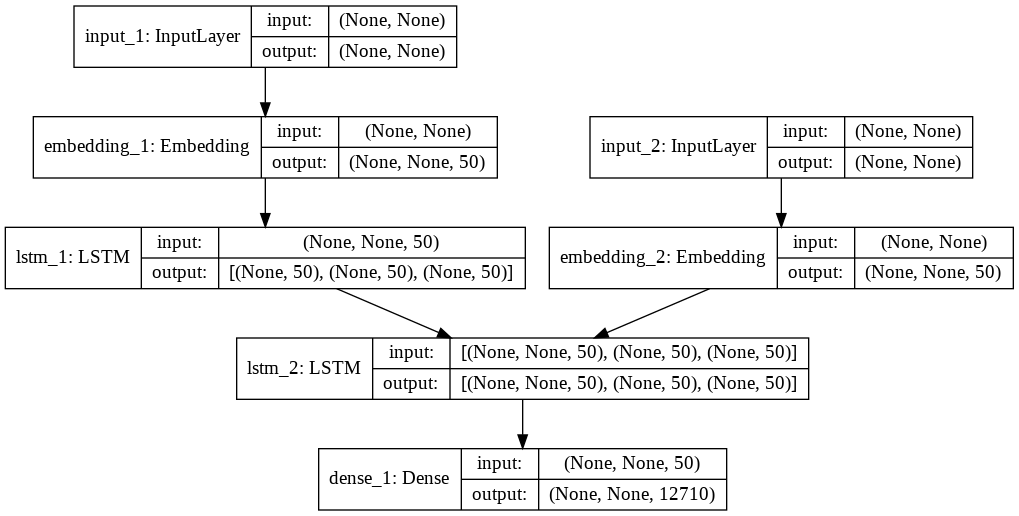

In [1]:
from IPython.display import Image
Image(retina=True, filename='train_model.png')

In [25]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

### Always remember to save the weights

In [44]:
model.save_weights('nmt_weights.h5')

### Load the weights, if you close the application

In [ ]:
model.load_weights('nmt_weights.h5')

### Inference Setup

In [45]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

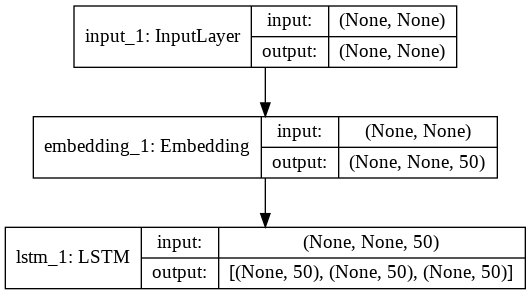

In [2]:
Image(retina=True, filename='encoder_model.png')

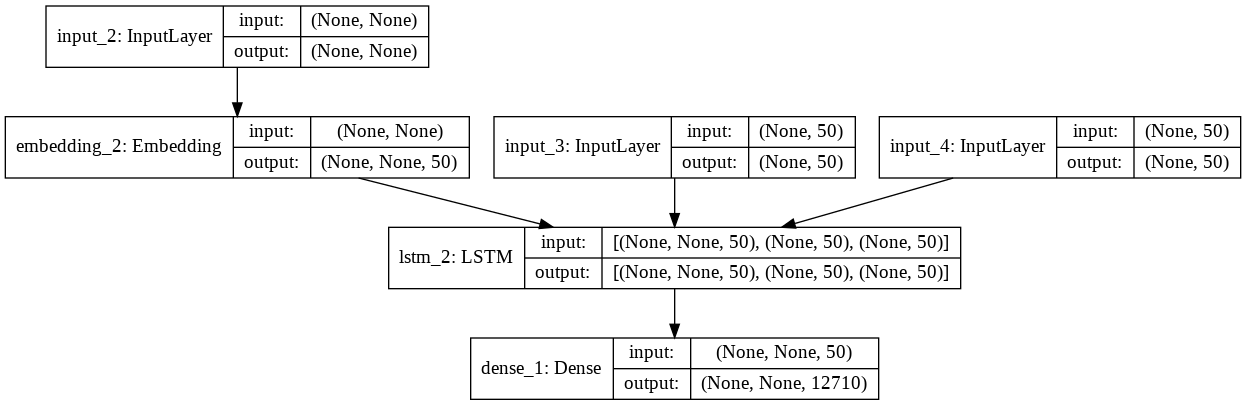

In [3]:
Image(retina=True, filename='decoder_model.png')

### Decode sample sequeces

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Evaluation on Train Dataset

In [47]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [48]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: elvis presley is one of the most famous singers
Actual Marathi Translation:  एलव्हिस प्रेसली सर्वात प्रसिद्ध गायकांमधील एक होता 
Predicted Marathi Translation:  सर्वात प्रसिद्ध मित्र नकोस 


In [49]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i will live in sasayama next year
Actual Marathi Translation:  मी पुढच्या वर्षी सासायामामध्ये राहेन 
Predicted Marathi Translation:  मी पुढच्या वर्षी सिद्ध बोलतो 


In [50]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it is a holiday tomorrow
Actual Marathi Translation:  उद्या सुट्टी आहे 
Predicted Marathi Translation:  उद्या नाताळ आहे 


In [51]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she didnt tell me her name
Actual Marathi Translation:  त्यांनी मला त्यांचं नाव सांगितलं नाही 
Predicted Marathi Translation:  तिने मला सांगितलं ते खरं नाव 


In [52]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what flower do you like best
Actual Marathi Translation:  तुला सर्वात जास्त कोणतं फूल आवडतं 
Predicted Marathi Translation:  तुला सर्वात जास्त खरं आहे का 


In [53]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i was asleep
Actual Marathi Translation:  मी झोपलेले 
Predicted Marathi Translation:  मी रडत होतो 


In [54]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i will give you this book
Actual Marathi Translation:  मी तुम्हाला हे पुस्तक देईन 
Predicted Marathi Translation:  मी तुला हे पुस्तक तुला दिलं 


In [55]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its night
Actual Marathi Translation:  रात्र आहे 
Predicted Marathi Translation:  रात्र आहे 


In [56]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this sentence has five words
Actual Marathi Translation:  या वाक्यात पाच शब्द आहेत 
Predicted Marathi Translation:  या पाच शब्द आहेत 


In [57]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: four more are needed to make fifty
Actual Marathi Translation:  पन्नास व्हायला आजून चार लागतील 
Predicted Marathi Translation:  चार गाड्या आमच्याबरोबर करायची तर या 


In [58]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: did you clean your room
Actual Marathi Translation:  तुझी खोली साफ केलीस का 
Predicted Marathi Translation:  तुझी खोली साफ केली का 


In [59]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she wrapped herself in a blanket
Actual Marathi Translation:  त्यांनी स्वतःला एका चादरीत गुंडाळून घेतलं 
Predicted Marathi Translation:  तिने एका छोट्या चादर घातली 


In [60]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he is still alive
Actual Marathi Translation:  तो अजूनही जिवंत आहे 
Predicted Marathi Translation:  ते अजूनही जिवंत आहेत 


In [61]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: thats toms
Actual Marathi Translation:  ते टॉमचं आहे 
Predicted Marathi Translation:  ती टॉमची आहे 


In [62]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom was eating a sandwich
Actual Marathi Translation:  टॉम सँडविच खात होता 
Predicted Marathi Translation:  टॉम सँडविच खात होता 


In [63]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: whats your favorite swear word
Actual Marathi Translation:  तुझी सर्वात आवडती शिवी कोणती आहे 
Predicted Marathi Translation:  तुझी सर्वात आवडती कोणती एक मोठी आहे 


In [64]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i was in australia for three months last year
Actual Marathi Translation:  गेल्या वर्षी मी तीन महिने ऑस्ट्रेलियात होते 
Predicted Marathi Translation:  गेल्या वर्षी मी तीन महिने ऑस्ट्रेलियात होते 


In [65]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: take the next right
Actual Marathi Translation:  पुढचा राइट पकडा 
Predicted Marathi Translation:  बाजूला घे 


In [66]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: why do i need to learn french
Actual Marathi Translation:  मला फ्रेंच शिकायची काय गरज आहे 
Predicted Marathi Translation:  मला फ्रेंच शिकायची का आहे 


In [67]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we won the battle
Actual Marathi Translation:  आम्ही लढाई जिंकलो 
Predicted Marathi Translation:  आम्ही लढाई जिंकलो 


In [68]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: is that your sister
Actual Marathi Translation:  त्या तुमची बहीण आहेत का 
Predicted Marathi Translation:  ते तुझी बहीण आहे का 


In [69]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom and mary are playing a video game
Actual Marathi Translation:  टॉम व मॅरी एक व्हिडिओ गेम खेळतायत 
Predicted Marathi Translation:  टॉम आणि मेरी शर्ट कोणी वाचता येत नाही आहे 


In [70]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: you cant speak french can you
Actual Marathi Translation:  तुला फ्रेंच बोलता येत नाही ना 
Predicted Marathi Translation:  तुला फ्रेंच बोलता येत नाही का नाही माहीत 


In [71]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: toms strong
Actual Marathi Translation:  टॉम बलवान आहे 
Predicted Marathi Translation:  टॉम पूर्णपणे पीत आहे 


In [73]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom backed everything up on an external hard drive
Actual Marathi Translation:  टॉमने सर्वकाही एका एक्स्टर्नल हार्ड ड्राइव्हवर बॅकअप करून ठेवलं 
Predicted Marathi Translation:  टॉमने एक सर्व मुलांना एका छोट्या परत गावात 


In [74]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: take care
Actual Marathi Translation:  काळजी घ्या 
Predicted Marathi Translation:  काळजी घे 


In [75]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im a city girl
Actual Marathi Translation:  मी शहरी मुलगी आहे 
Predicted Marathi Translation:  मी एका मुलीला ओळखतो 


In [76]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tell me that story again
Actual Marathi Translation:  ती गोष्ट मला परत सांगा 
Predicted Marathi Translation:  मला ती गोष्ट परत सांगा 


In [77]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the clock has stopped
Actual Marathi Translation:  घड्याळ थांबलंय 
Predicted Marathi Translation:  घड्याळ बंद करा 


In [78]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i like your idea
Actual Marathi Translation:  मला तुमची आयडिया आवडली 
Predicted Marathi Translation:  मला तुझी ती आवडते 


In [79]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom has eaten three hot dogs so far
Actual Marathi Translation:  टॉमने आतापर्यंत तीन हॉटडॉग खाल्ले आहेत 
Predicted Marathi Translation:  टॉमने तीन वर्षांनी काही पुस्तकं आहेत 


In [80]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he may come today
Actual Marathi Translation:  ते आज येऊ शकतात 
Predicted Marathi Translation:  तो आज येऊ शकत नाही 


In [81]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: well done
Actual Marathi Translation:  शाब्बास 
Predicted Marathi Translation:  आम्ही केलं 


In [82]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: either you or i must go in his place
Actual Marathi Translation:  त्याच्या जागी तुला किंवा मलातरी जायलाच लागेल 
Predicted Marathi Translation:  मला वाटतं ते आठ इंग्रजी हवी आहे 


In [83]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do you like moscow
Actual Marathi Translation:  तुम्हाला मॉस्को आवडतं का 
Predicted Marathi Translation:  तुला आवडलं का 


In [84]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do you write in arabic
Actual Marathi Translation:  तुम्ही अरबीत लिहिता का 
Predicted Marathi Translation:  तू अरबी तू अमेरिकेत नाहीस 


In [85]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its very hot inside
Actual Marathi Translation:  आत खूप गरम आहे 
Predicted Marathi Translation:  खूप गरम होतं 


In [86]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i am memorizing the national anthem
Actual Marathi Translation:  मी राष्ट्रगीत पाठ करतेय 
Predicted Marathi Translation:  मी विसरणार नाही 


In [87]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont understand why tom brought you here
Actual Marathi Translation:  टॉमने तुला इथे का आणलं मला कळत नाही 
Predicted Marathi Translation:  टॉम इथे काल का आणलं मला माहीत आहे 


In [88]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what did you do exactly
Actual Marathi Translation:  तुम्ही नक्की काय केलंत 
Predicted Marathi Translation:  तू नक्की काय केलंस 


In [89]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive studied english for five years
Actual Marathi Translation:  मी पाच वर्ष इंग्रजीचा अभ्यास केला आहे 
Predicted Marathi Translation:  मी इंग्रजीचा अभ्यास केला जातो 


In [90]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we will win the battle
Actual Marathi Translation:  आम्ही ही लढाई जिंकू 
Predicted Marathi Translation:  आपण ते जिंकू शकतो का 


In [91]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont like chess
Actual Marathi Translation:  मला बुद्धिबळ आवडत नाही 
Predicted Marathi Translation:  मला बुद्धिबळ आवडत नाही 


In [92]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what did you eat last night
Actual Marathi Translation:  तुम्ही काल रात्री काय खाल्लंत 
Predicted Marathi Translation:  तू काल रात्री काय केलंस 


In [93]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do it just like this
Actual Marathi Translation:  अगदी असंच करा 
Predicted Marathi Translation:  हे फक्त हवं आहे 


In [94]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont you want my phone number
Actual Marathi Translation:  माझा फोन नंबर नकोय का 
Predicted Marathi Translation:  तुला माझा फोन कोणी नंबर आहे का 


In [95]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its no problem for me to help you tomorrow morning
Actual Marathi Translation:  उद्या सकाळी तुमची मदत करण्यात मला काहीच हरकत नाही 
Predicted Marathi Translation:  इथे मी तुझी मदत करून विचार ताबडतोब नाही 


In [96]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what time do you want to meet
Actual Marathi Translation:  तुम्हाला किती वाजता भेटायचं आहे 
Predicted Marathi Translation:  तुला किती वाजता भेटायचं आहे 


In [97]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: let her sleep
Actual Marathi Translation:  तिला झोपू दे 
Predicted Marathi Translation:  तिला द्या 


In [98]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: your dog is here
Actual Marathi Translation:  तुझा कुत्रा इकडे आहे 
Predicted Marathi Translation:  तुझा कुत्रा इथे आहे 


In [99]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who called the cops
Actual Marathi Translation:  पोलिसांना कोणी बोलवलं 
Predicted Marathi Translation:  पोलिसांना कोणी बोलवलं 


In [100]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: are you a prisoner
Actual Marathi Translation:  तुम्ही कैदी आहात का 
Predicted Marathi Translation:  तुम्ही कैदी आहात का 


### Evaluation on Validation Dataset

In [101]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [102]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i want some tea without sugar
Actual Marathi Translation:  मला थोडा बिनसाखरेचा चहा हवाय 
Predicted Marathi Translation:  मला जरासा चहा देऊ शकता 


In [103]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: my wife isnt beautiful yours is
Actual Marathi Translation:  माझी बायको सुंदर नाहीये तुझी आहे 
Predicted Marathi Translation:  माझी तुझी गर्लफ्रेंड सुंदर आहे भेटलो 


In [104]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i wasnt stealing anything
Actual Marathi Translation:  मी काहीही चोरत नव्हते 
Predicted Marathi Translation:  मी काहीही काहीही दिसला 


In [105]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who lives in this house
Actual Marathi Translation:  या घरात कोण राहतं 
Predicted Marathi Translation:  या घरात कोणी असतो 


In [106]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: am i dreaming
Actual Marathi Translation:  मी स्वप्न बघतेय का 
Predicted Marathi Translation:  मी स्वप्न बघतोय का 


In [107]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: somethings happened to tom
Actual Marathi Translation:  टॉमला काहीतरी झालंय 
Predicted Marathi Translation:  टॉमला काहीतरी झालं आहे 


In [108]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: come on give it to me
Actual Marathi Translation:  चला द्या मला 
Predicted Marathi Translation:  मला आत आला तर 


In [109]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she shot him
Actual Marathi Translation:  त्यांनी त्याला गोळी मारली 
Predicted Marathi Translation:  तिने त्याला गोळी मारली 


In [110]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: all knowledge is not good
Actual Marathi Translation:  सर्वच ज्ञान काय चांगलं नसतं 
Predicted Marathi Translation:  चांगल्या घाईत लोकं नाहीयेत 


In [111]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom isnt dead
Actual Marathi Translation:  टॉम मेला नाहीये 
Predicted Marathi Translation:  टॉम मेला नाहीये 


In [112]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: just work hard
Actual Marathi Translation:  फक्त मेहनतीने काम कर 
Predicted Marathi Translation:  खूप वर्ष करू शकतं 


In [113]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tell tom to wait
Actual Marathi Translation:  टॉमला थांबायला सांग 
Predicted Marathi Translation:  टॉमला थांबायला सांगा 


In [114]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the dog jumped over a chair
Actual Marathi Translation:  कुत्र्याने खुर्चीवरून उडी मारली 
Predicted Marathi Translation:  एक कुत्र्याला दरवाजा बंद केला 


In [115]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i like short hair
Actual Marathi Translation:  मला छोटे केस आवडतात 
Predicted Marathi Translation:  मला नियम आवडतो 


In [116]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i can prove who the murderer is
Actual Marathi Translation:  खुनी कोण आहे हे मी सिद्ध करू शकतो 
Predicted Marathi Translation:  मी जिंकू शकतो हे मला माहीत आहे 


In [117]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom is a guest
Actual Marathi Translation:  टॉम पाहुणा आहे 
Predicted Marathi Translation:  टॉम एक भिंत बघितला आहे 


In [118]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: how will you stop him
Actual Marathi Translation:  तुम्ही त्याला कसं थांबवाल 
Predicted Marathi Translation:  तू त्यांना जबाबदार 


In [119]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everyone could hear what tom said
Actual Marathi Translation:  टॉम जे म्हणाला ते सर्वांना ऐकू येत होतं 
Predicted Marathi Translation:  टॉमने काय म्हटलं म्हटलं तर खरं 


In [120]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: those are my books
Actual Marathi Translation:  ती माझी पुस्तकं आहेत 
Predicted Marathi Translation:  ती माझी पुस्तकं आहेत 


In [121]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i cant see anything
Actual Marathi Translation:  मला काहीही दिसत नाहीये 
Predicted Marathi Translation:  मला काहीही दिसत नाहीये 


In [122]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the main crop of japan is rice
Actual Marathi Translation:  जपानमध्ये प्रमुख धान्य म्हणजे तांदूळ 
Predicted Marathi Translation:  जपानमध्ये किती तास 


In [123]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it wasnt mine
Actual Marathi Translation:  माझा नव्हता 
Predicted Marathi Translation:  माझं नव्हतं 


In [124]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they said anderson and his men must leave the fort
Actual Marathi Translation:  त्यांनी म्हटलं की अॅंडरसन व त्याच्या माणसांनी गड सोडला पाहिजे 
Predicted Marathi Translation:  त्याने प्रत्येक टॉमच्या प्रश्न व शकतो 


In [125]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom looks like hes going to cry
Actual Marathi Translation:  टॉमला बघून वाटतंय तो रडणार आहे 
Predicted Marathi Translation:  टॉम बागेत तो विसरले 


In [126]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i reached nagoya early this morning
Actual Marathi Translation:  मी आज सकाळी पहाटेच नागोयाला पोहोचलो 
Predicted Marathi Translation:  मी आज सकाळी लवकरच सुरू केला 


In [127]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: let me talk to tom first
Actual Marathi Translation:  आधी मला टॉमशी बोलू द्या 
Predicted Marathi Translation:  मला टॉमशी बोलू शकत नव्हते 


In [128]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she took my hand
Actual Marathi Translation:  त्यांनी माझा हात घेतला 
Predicted Marathi Translation:  तिने माझा हात 


In [129]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everybody wants recognition
Actual Marathi Translation:  सर्वांनाच मान्यता हवी असते 
Predicted Marathi Translation:  सगळे चांगले जात आहोत 


In [130]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom doesnt like wearing red
Actual Marathi Translation:  टॉमला लाल कपडे घालायला आवडत नाहीत 
Predicted Marathi Translation:  टॉमने मोठ्या शहरात नाहीत 


In [131]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im resigning on monday
Actual Marathi Translation:  मी सोमनारी राजीनामा देत आहे 
Predicted Marathi Translation:  मी सोमवारी खूष आहे 


In [132]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom has been to boston twice
Actual Marathi Translation:  टॉम बॉस्टनला दोनदा गेला आहे 
Predicted Marathi Translation:  टॉम बॉस्टनला दोन वेळा झाला आहे 


In [133]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the keys were in my bag
Actual Marathi Translation:  चाव्या माझ्या बॅगेत होत्या 
Predicted Marathi Translation:  माझ्या चाव्या खोलीत आहेत 


In [134]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: everyone knew the song
Actual Marathi Translation:  गाणं सर्वांनाच माहीत होतं 
Predicted Marathi Translation:  ते गाणं सर्वांनाच माहीत आहे 


In [135]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: are those your bags
Actual Marathi Translation:  त्या तुझ्या बॅगा आहेत 
Predicted Marathi Translation:  त्या तुझ्या बॅगा आहेत 


In [136]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: money doesnt grow on trees you know
Actual Marathi Translation:  पैसे काय झाडावर नाही उगत 
Predicted Marathi Translation:  माहीत आहे विसरणार नाही का 


In [137]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i watched the news
Actual Marathi Translation:  मी बातम्या बघितल्या 
Predicted Marathi Translation:  मी बातमी स्वतः पाहिलं 


In [138]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who built it
Actual Marathi Translation:  ते कोणी बांधलं 
Predicted Marathi Translation:  कोणी करेन 


In [139]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: when did you buy your car
Actual Marathi Translation:  तुम्ही आपली गाडी कधी विकत घेतलीत 
Predicted Marathi Translation:  तू तुझी गाडी कधी विकत घेतली 


In [140]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: pakistan is a muslim country
Actual Marathi Translation:  पाकिस्तान हा मुस्लिम देश आहे 
Predicted Marathi Translation:  देश ठाऊक आहे 


In [141]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom is in his bedroom
Actual Marathi Translation:  टॉम त्याच्या बेडरूममध्ये आहे 
Predicted Marathi Translation:  टॉम त्याच्या बहिणी आहे 


In [142]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: can you do that tomorrow
Actual Marathi Translation:  ते तू उद्या करू शकतेस का 
Predicted Marathi Translation:  ते तू त्यांना करू शकतोस का 


In [143]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she can speak french
Actual Marathi Translation:  त्यांना फ्रेंच बोलता येते 
Predicted Marathi Translation:  तिला फ्रेंच बोलता येते 


In [144]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont stand up
Actual Marathi Translation:  उभा राहू नकोस 
Predicted Marathi Translation:  सोडू नकोस 


In [145]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: fold the paper in the middle
Actual Marathi Translation:  कागदाला मधून घडी घाल 
Predicted Marathi Translation:  ब्रेड हा दूर व शकतोस 


In [146]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: my son is going to be a teacher
Actual Marathi Translation:  माझा मुलगा शिक्षक बनणार आहे 
Predicted Marathi Translation:  माझा लहान भाऊ शिक्षक आहे 


In [147]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: can you ride a bicycle
Actual Marathi Translation:  तुम्हाला सायकल चालवता येते का 
Predicted Marathi Translation:  तुला सायकल चालवता येते का 


In [148]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im extremely fat
Actual Marathi Translation:  मी अतिशय जाडा आहे 
Predicted Marathi Translation:  मी खूप जाडी आहे 


In [149]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive just turned
Actual Marathi Translation:  मी आत्ताच वर्षांचा झालो आहे 
Predicted Marathi Translation:  मी फक्त माझ्या मित्राला वाट घेतली 


In [150]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ive found a job
Actual Marathi Translation:  मला नोकरी सापडली आहे 
Predicted Marathi Translation:  मला एक नोकरी सापडलं 
